In [1]:
!pip install matplotlib
!pip install qutip
!pip install numpy 
!pip install scipy
!pip install Cython  

In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import toolkit_proj_ev as me

from IPython.display import display, Math, Latex

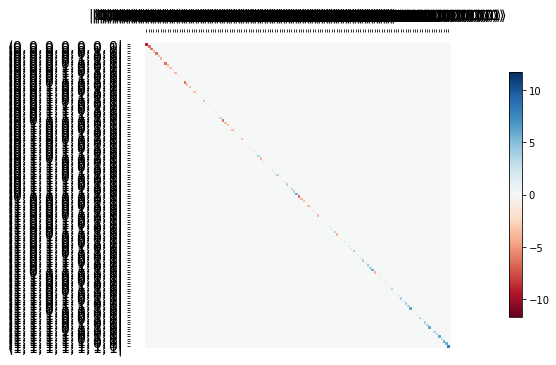

In [20]:
N = 7
Jx = .15
Jy = .25 
Jz = .1
h = 1.

## Operadores de spin y hamiltoniano

## solo 1-operadores
globalid_list, sx_list, sy_list, sz_list = me.one_body_spin_ops(N)
pauli_vec = [sx_list, sy_list, sz_list]

## upto 2-opeadores ie. armé una lista de listas, con 1-operadores y 2-operadores 
## pero todos actuando sobre el espacio de Hilbert global 2^N dimensional H = \otimes_{j}^{N} h_j 
two_body_spin_list = me.two_body_spin_ops(N, True)

## Hamiltoniano 
H_H = me.Heisenberg_Hamiltonian("XXX", N, True, Jx, Jy, Jz, h)

### Free particle-Operators en términos de los operadores de spin
x_op, p_op, comm_xp, corr_xp, p_dot = me.classical_ops("XXX", N, Jx, Jy, Jz, h)

In [21]:
N = 3
psi1_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list)
psi0 = psi01 #+psi02 #sí está en el ME2, aparece un proyector s1, s2 -> estado ME2

loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])
#me.initial_state(2, False, None, .5, None, psi0, True)

psi0

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1.25000589e-01+0.00000000e+00j 1.96350158e-07-1.96350158e-07j
  1.96350158e-07-1.96350158e-07j 0.00000000e+00+0.00000000e+00j
  1.96350158e-07-1.96350158e-07j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [1.96350158e-07+1.96350158e-07j 1.25000196e-01+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 1.96349541e-07-1.96349541e-07j
  0.00000000e+00+0.00000000e+00j 1.96349541e-07-1.96349541e-07j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [1.96350158e-07+1.96350158e-07j 0.00000000e+00+0.00000000e+00j
  1.25000196e-01+0.00000000e+00j 1.96349541e-07-1.96349541e-07j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  1.96349541e-07-1.96349541e-07j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 1.96349541e-07+1.96349541e-07j
  1.96349541e-07+1.96349541e-07j 1.24999804e-01+0.00000000e+00j

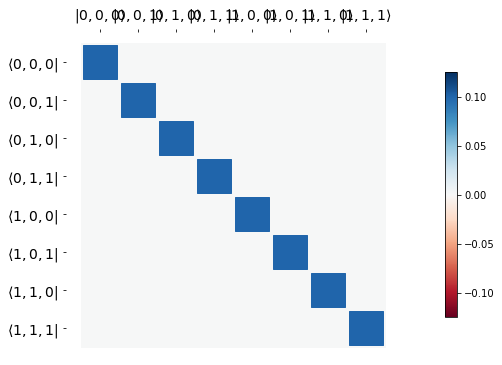

In [22]:
a = len(me.one_body_spin_ops(N))
b = len(me.one_body_spin_ops(N)[0])

coeffs_me1 = np.pi * 10**-6 * np.full((a,b),1.)

me.n_body_max_ent_state(1, N, coeffs_me1, None, True)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.25002356e-01+0.00000000e+00j  9.81763434e-07-9.81763434e-07j
   9.81763434e-07-9.81763434e-07j  0.00000000e+00-3.92712036e-07j
   9.81763434e-07-9.81763434e-07j  0.00000000e+00-3.92712036e-07j
   0.00000000e+00-3.92712036e-07j -5.55170480e-12-5.55170480e-12j]
 [ 9.81763434e-07+9.81763434e-07j  1.25000393e-01+0.00000000e+00j
   3.92712036e-07+0.00000000e+00j  5.89051398e-07-5.89051398e-07j
   3.92712036e-07+0.00000000e+00j  5.89051398e-07-5.89051398e-07j
   5.55170480e-12-5.55170480e-12j  0.00000000e+00-3.92700932e-07j]
 [ 9.81763434e-07+9.81763434e-07j  3.92712036e-07+0.00000000e+00j
   1.25000393e-01+0.00000000e+00j  5.89051398e-07-5.89051398e-07j
   3.92712036e-07+0.00000000e+00j  5.55170480e-12-5.55170480e-12j
   5.89051398e-07-5.89051398e-07j  0.00000000e+00-3.92700932e-07j]
 [ 0.00000000e+00+3.92712036e-07j  5.89051398e-07+5.89051398e-07j
   5.89051398e-07+5.89051398e-07j  1.

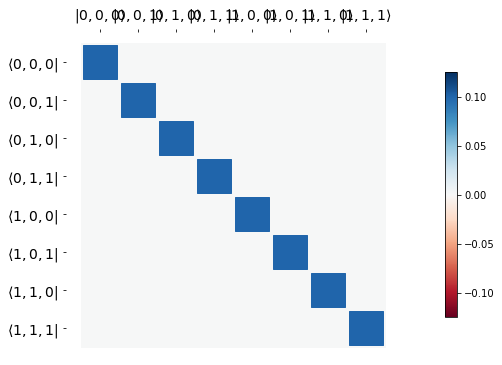

In [23]:
a = len(me.two_body_spin_ops(N, True))
b = len(me.two_body_spin_ops(N, True)[0])

coeffs_me2 = np.pi * 10**-6 * np.full((a,b),1.)

me.n_body_max_ent_state(2, N, coeffs_me2, True, True)


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1.25000589e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.24999804e-01 3.92699082e-07 0.00000000e+00
  3.92699082e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.92699082e-07 1.24999804e-01 0.00000000e+00
  3.92699082e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.24999804e-01
  0.00000000e+00 3.92699082e-07 3.92699082e-07 0.00000000e+00]
 [0.00000000e+00 3.92699082e-07 3.92699082e-07 0.00000000e+00
  1.24999804e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.92699082e-07
  0.00000000e+00 1.24999804e-01 3.92699082e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.92699082e-07
  0.00000000e+00 3.92699082e-07 1.24999804e-01 0.00000000e+00]
 [0.00000000e+00 0.0000

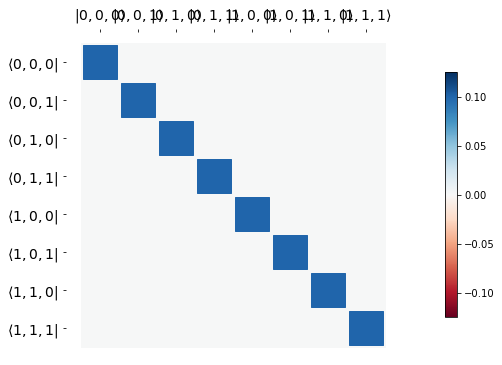

In [24]:
a = len(me.two_body_spin_ops(N, False))
b = len(me.two_body_spin_ops(N, False)[0])

coeffs_me2 = np.pi * 10**-6 * np.full((a,b),1.)

me.n_body_max_ent_state(2, N, coeffs_me2, False, True)


In [25]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

def projected_evolution(N, chain_type = "XXX", author=True, x=.5, gamma = 1*np.e*-2, 
                        omega_1=3., omega_2=3.,temp=1, 
                        gaussian=False, gr = 1, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        coeffs_me1_gr1 = [[10**-1,2*10**-1],[np.pi*10**-1,10**-18],
                          [10**-18,10**-18],[10**-18,10**-18]]
        rho0 = me.initial_state(N, True, 1, None, coeffs_me1_gr1, None, False)
    elif(gaussian and gr == 2):
        a = len(me.all_two_body_spin_ops(N))
        b = len(me.all_two_body_spin_ops(N)[0])

        coeffs_me2_gr2 = 10**-2 * np.full((a,b),1.)
        rho0 = me.initial_state(N, True, 2, None, coeffs_me2_gr2, None, False)
             
    elif(not gaussian):
        psi1_list = []
        psi1_list.append(qutip.basis(2,1))
        for n in range(N-1):
            psi1_list.append(qutip.basis(2,0))

        psi0 = qutip.tensor(psi1_list)
        rho0 = me.initial_state(N, False, None, x, None, psi0, False)
         
    if (author):
        basis = me.base_orth(me.n_body_basis(2, N), rho0)  ## // Á la Tom
    else: 
        lista_ampliada = []
        for i in range(len(me.n_body_basis(1, N))):
            lista_ampliada.append(qutip.tensor(me.n_body_basis(N,1)[i], qutip.qeye(2)))
        basis = me.base_orth(lista_ampliada, rho0) ## // Á la Mauricio
        
    obs = [x_op, p_op, comm_xp, corr_xp]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    #c_op_list = me.spin_dephasing(N, gamma, False)
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=me.Heisenberg_Hamiltonian(chain_type, N, False, Jx, Jy, Jz, h), 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               #c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
sampling: 30


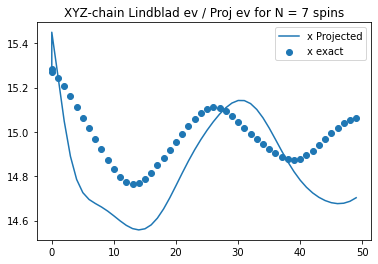

In [26]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(7, "XYZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(7, "XYZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.title("XYZ-chain Lindblad ev / Proj ev for N = 7 spins")
plt.legend()



In [46]:
psi1_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi0 = qutip.tensor(psi1_list)
rho0 = me.initial_state(N, False, None, .5, None, psi0, False)

b = me.n_body_basis(gr = 2, N = 3)
me.base_orth(b, rho0)

[Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]],
 Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]],
 Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]],
 Quantum o